# From model to production

## Picking a problem

### The state of deep learning

### The Drivetrain approach

### Starting your project

## Gathering data

In [ ]:
key = os.environ['AZURE_SEARCH_KEY']

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [ ]:
fns = get_image_files(path)
fns

(#421) [Path('bears/black/00000095.jpg'),Path('bears/black/00000133.jpg'),Path('bears/black/00000062.jpg'),Path('bears/black/00000023.jpg'),Path('bears/black/00000029.jpg'),Path('bears/black/00000094.jpg'),Path('bears/black/00000124.jpg'),Path('bears/black/00000056.jpeg'),Path('bears/black/00000046.jpg'),Path('bears/black/00000045.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
?verify_images

### Sidebar: Getting help in jupyter notebooks

### End sidebar

In [ ]:
failed.map(Path.unlink);

## From data to DataLoaders

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path, item_tfms=Resize(128))

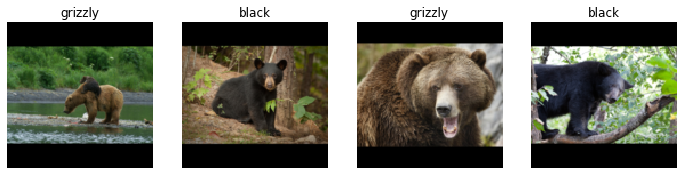

In [ ]:
dls.valid.show_batch(max_n=4, rows=1)

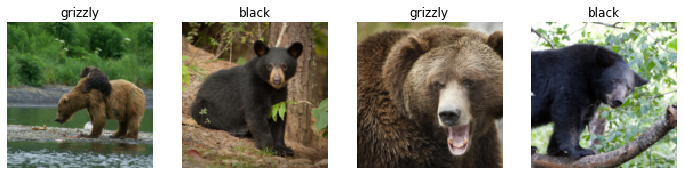

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Crop))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, rows=1)

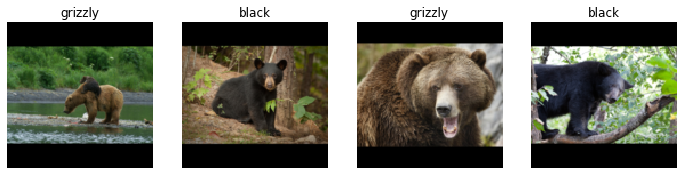

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, rows=1)

## Data augmentation

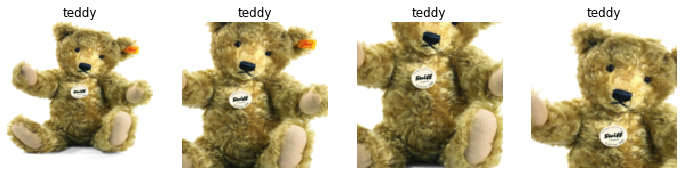

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, rows=1)

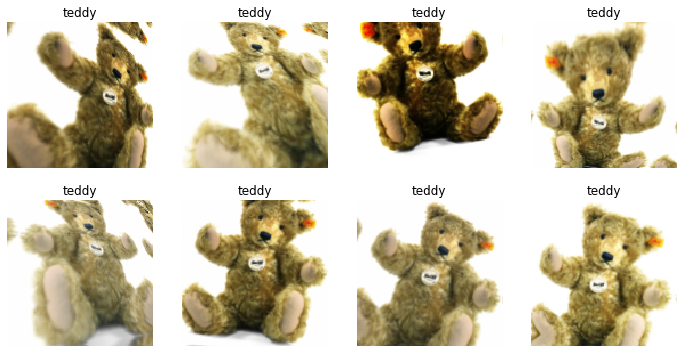

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, rows=2)

## Training your model, and using it to clean your data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.235733,0.212541,0.087302,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.213371,0.112450,0.023810,00:05
1,0.173855,0.072306,0.023810,00:06
2,0.147096,0.039068,0.015873,00:06
3,0.123984,0.026801,0.015873,00:06


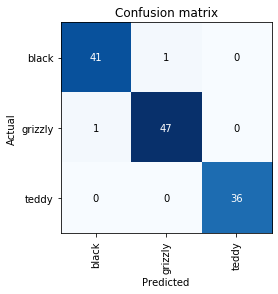

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

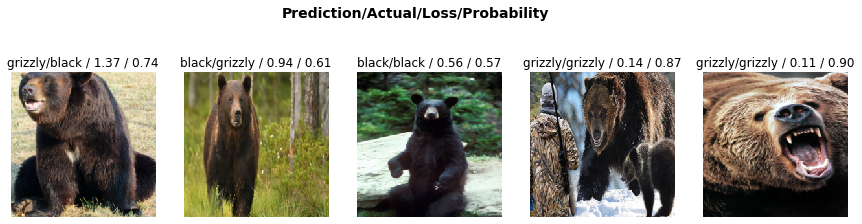

In [ ]:
interp.plot_top_losses(5, rows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Turning your model into an online application

### Using the model for inference

In [ ]:
learn.export()

In [ ]:
path = Path()
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.0767e-06, 9.9999e-01, 1.5748e-07]))

In [ ]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

### Creating a Notebook app from the model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a real app

### Deploying your app

## How to avoid disaster

### Unforeseen consequences and feedback loops

## Get writing!

### You should blog

### Creating the repository

### Setting up your homepage

### Creating posts

### Synchronizing GitHub and your computer

### Jupyter for blogging

## Now it's your turn